In [40]:
import numpy as np
from matplotlib import pyplot as plt
import pickle as pkl

In [47]:
np.log(0.1)/np.log(0.99)

229.1052882766942

In [46]:
np.log(0.1)/np.log(0.95)

44.89056748035484

## The plotting handler

In [2]:
def plot_with_errorband(ax,trial_data,indices = None,label=''):
    mu = np.mean(trial_data,axis=0)
    std = np.std(trial_data,axis=0)

    if indices is None:
        indices = range(len(mu))
    
    ax.plot(indices,np.array(mu),label=label)
    ax.fill_between(indices,mu+std,mu-std,alpha=0.2)

In [3]:
def cost(Q,hist):
    n_trial = hist.shape[0]
    timesteps = hist.shape[1]
    Q_cost = [hist[i,j].T.dot(Q).dot(hist[i,j]) for i in range(n_trial) for j in range(timesteps)]

    Q_cost = np.array(Q_cost).reshape(n_trial,timesteps)
    return Q_cost

# Total LQR Cost vs $\bar{\eta}$

In [4]:
# etas = [0.01,0.05,0.1,0.5]+list(np.arange(1.0,5.25,0.25))
# etas = [0,0.1,0.5,1.0,1.5,2.0]
# etas = [0.5,1.0,2.0]+[2.5,3.0,3.5,4.0,4.5]
etas = [0.1]+list(np.arange(0.5,2.0,0.1))+[2.5,3.0,3.5,4.0,4.5]
# etas = [0,2.0]
# etas = [0.01,0.05,0.1]
# etas = np.arange(0,0.5,0.02)
control_alg = ['SafeLearning','Benchmark']

In [5]:
data = {}
  
costs = {alg:[] for alg in control_alg}

A_errors = {alg:[] for alg in control_alg}
B_errors = {alg:[] for alg in control_alg}

for alg in control_alg:

    for eta in etas:
        with open('./data/{}_eta_{}.pkl'.format(alg,eta),'rb') as f:
            data[eta] = pkl.load(f)

    with open('./data/Parameters.pkl','rb') as f:
        data['Parameters'] = pkl.load(f)

    Q = data['Parameters']['Q']
    R = data['Parameters']['R']
    A = data['Parameters']['A']
    B = data['Parameters']['B']


    mean_cost = []
    std_cost = []

    for eta in etas:
        x_hist = np.array([d['x'] for d in data[eta]])
        u_hist = np.array([d['u'] for d in data[eta]])

        c = np.sum(cost(Q,x_hist),axis=-1)+np.sum(cost(R,u_hist[:,:,np.newaxis,np.newaxis]),axis=-1)
        costs[alg].append(c)
        
    costs[alg] = np.array(costs[alg])




Text(0, 0.5, 'LQR Cost')

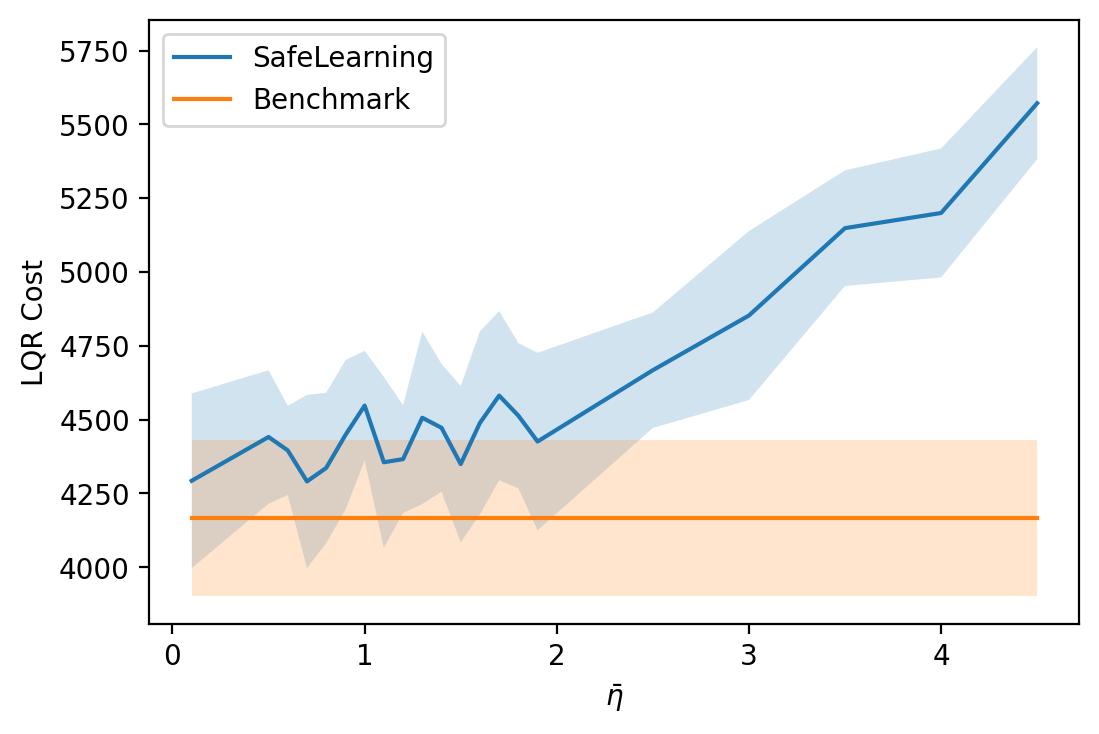

In [6]:

plt.figure(dpi=200)
plot_with_errorband(plt.gca(),costs['SafeLearning'].T,etas,'SafeLearning')
plot_with_errorband(plt.gca(),costs['Benchmark'][:,2].T.reshape(-1,1).dot(np.ones((1,len(costs['Benchmark'])))),etas,'Benchmark')

# plot_with_errorband(plt.gca(),(costs['SafeLearning']-costs['Benchmark']).T,etas,'Regret')


plt.legend()
plt.xlabel(r'$\bar{\eta}}$')
plt.ylabel('LQR Cost')

In [7]:
A = data['Parameters']['A']
B = data['Parameters']['B']  

A_errors = []
B_errors = []
theta_errors = []

for eta in etas:
    with open('./data/SafeLearning_eta_{}.pkl'.format(eta),'rb') as f:
        data[eta] = pkl.load(f)



for eta in etas:

    thetas = [d['theta'] for d in data[eta]]

    As = np.array([[t[0] for t in theta_hist] for theta_hist in thetas])
    Bs = np.array([[t[1] for t in theta_hist] for theta_hist in thetas])

    # As.shape = (# trials, # refits, x_dim, x_dim)
    # Bs.shape = (# trials, # refits, x_dim, u_dim)
    
    A_diff = np.linalg.norm(As[:,-1,:,:]-A,'fro',axis=(-1,-2))
    B_diff = np.linalg.norm(Bs[:,-1,:,:]-B,'fro',axis=(-1,-2))
    
    theta_diff = np.sqrt(A_diff**2+B_diff**2)
    
    A_errors.append(A_diff)
    B_errors.append(B_diff)
    theta_errors.append(theta_diff)
    
A_errors = np.array(A_errors)
B_errors = np.array(B_errors)

theta_errors = np.array(theta_errors)


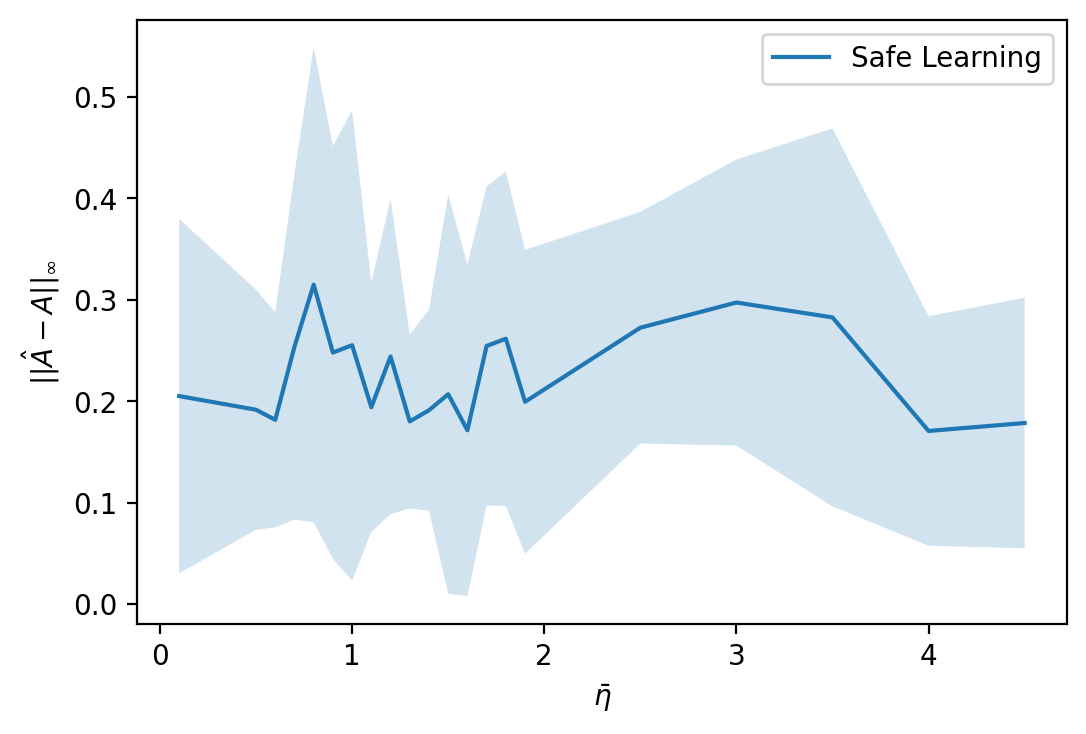

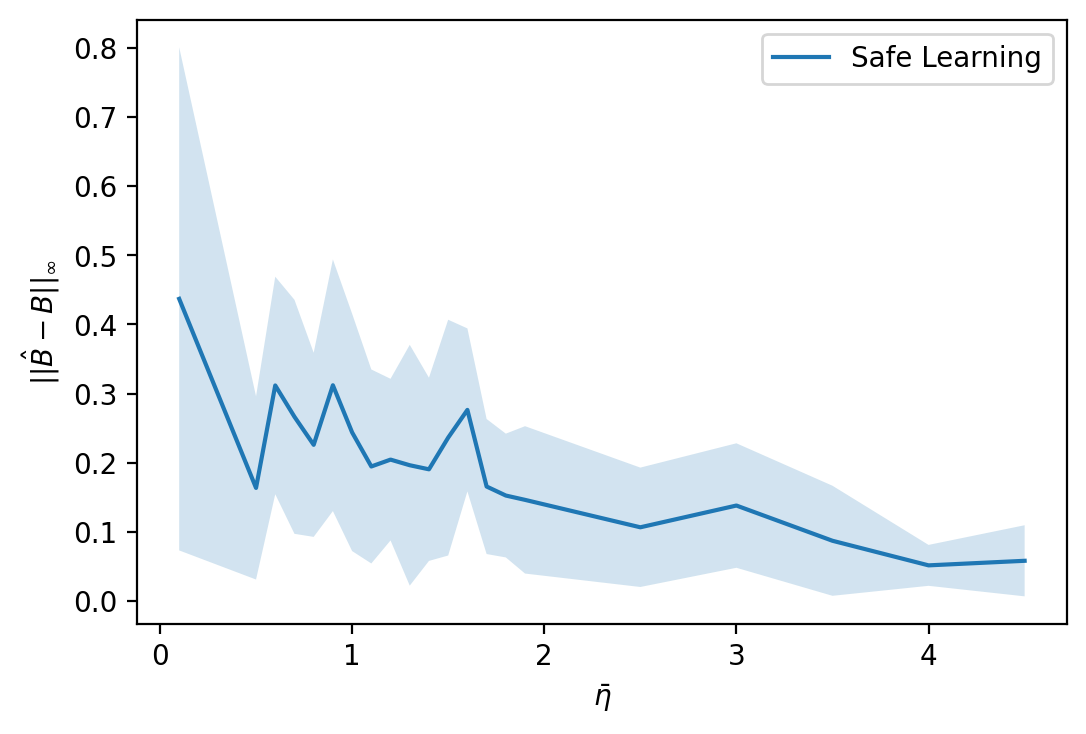

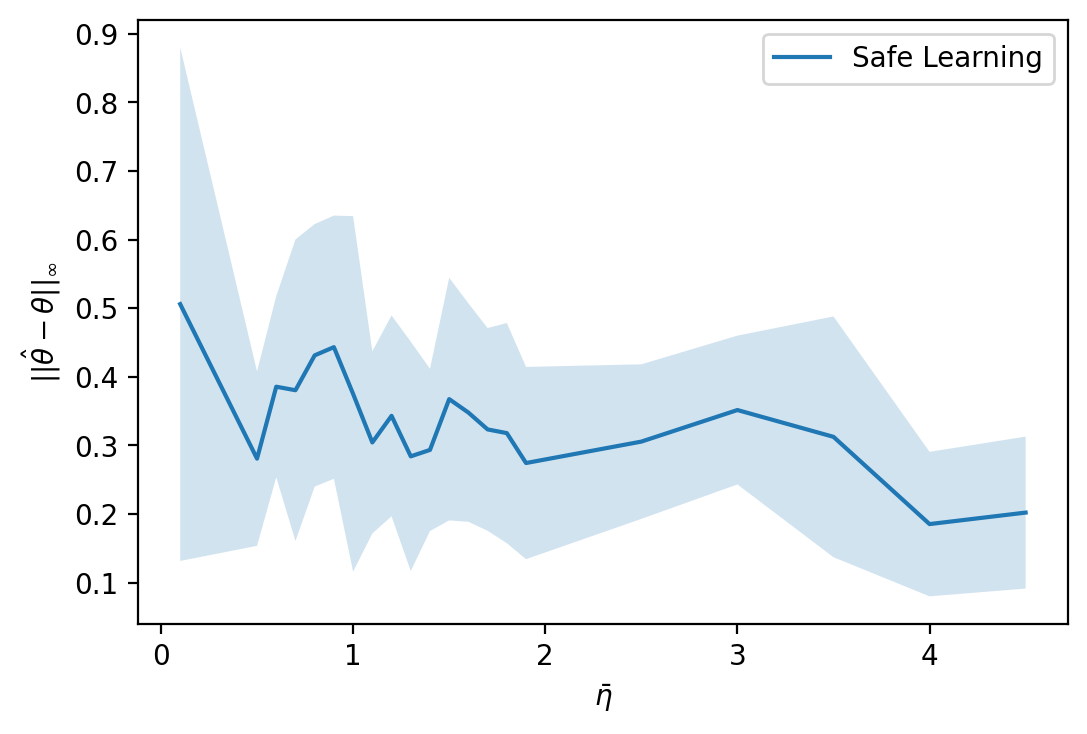

In [8]:

plt.figure(dpi=200)
plot_with_errorband(plt.gca(),A_errors.T,etas,'Safe Learning')

plt.legend()
plt.xlabel(r'$\bar{\eta}}$')
plt.ylabel(r'$||\hat{A}-A||_{\infty}$')
plt.show()


plt.figure(dpi=200)
plot_with_errorband(plt.gca(),B_errors.T,etas,'Safe Learning')

plt.legend()
plt.xlabel(r'$\bar{\eta}}$')
plt.ylabel(r'$||\hat{B}-B||_{\infty}$')
plt.show()

plt.figure(dpi=200)
plot_with_errorband(plt.gca(),theta_errors.T,etas,'Safe Learning')

plt.legend()
plt.xlabel(r'$\bar{\eta}}$')
plt.ylabel(r'$||\hat{\theta}-\theta||_{\infty}$')
plt.show()

## LQR Stage Regret vs $t$

In [10]:
Q = data['Parameters']['Q']
R = data['Parameters']['R']

control_cost = {}
for alg in control_alg:
    with open('./data/{}_eta_0.1.pkl'.format(alg),'rb') as f:
        dat = pkl.load(f)
        
    x_hist = np.array([np.array(d['x']) for d in dat])
    u_hist = np.array([np.array(d['u']) for d in dat])
    control_cost[alg] = cost(Q,x_hist) + cost(R,u_hist[:,:,np.newaxis,np.newaxis])


dict_keys([0.1, 0.5, 0.6, 0.7, 0.7999999999999999, 0.8999999999999999, 0.9999999999999999, 1.0999999999999999, 1.1999999999999997, 1.2999999999999998, 1.4, 1.4999999999999998, 1.5999999999999996, 1.6999999999999997, 1.7999999999999998, 1.8999999999999997, 2.5, 3.0, 3.5, 4.0, 4.5, 'Parameters'])

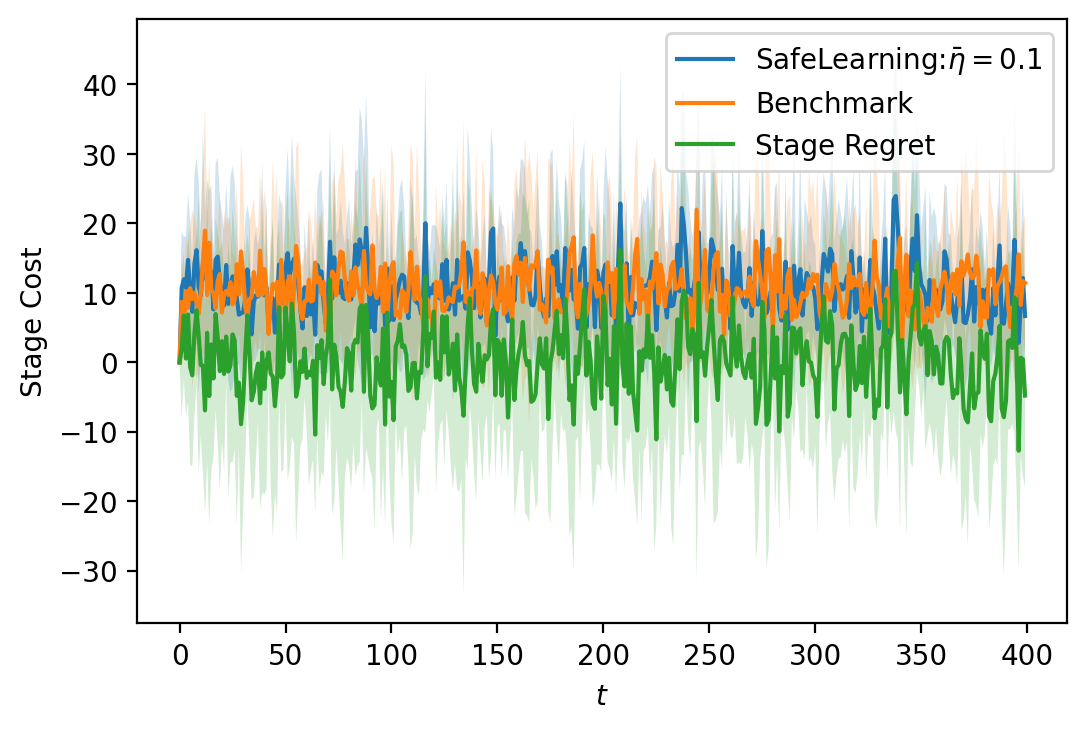

In [33]:
plt.figure(dpi=200)
ax = plt.gca()
for key,item in control_cost.items():
    
    if key == "SafeLearning":
         plot_with_errorband(ax,item,label=r"{}:$\bar\eta={}$".format(key,0.1))
    else:
        plot_with_errorband(ax,item,label=key)

plot_with_errorband(ax,control_cost['SafeLearning']-control_cost['Benchmark'],label='Stage Regret')
ax.set_ylabel('Stage Cost')
ax.set_xlabel(r'$t$')
ax.legend()
plt.show()

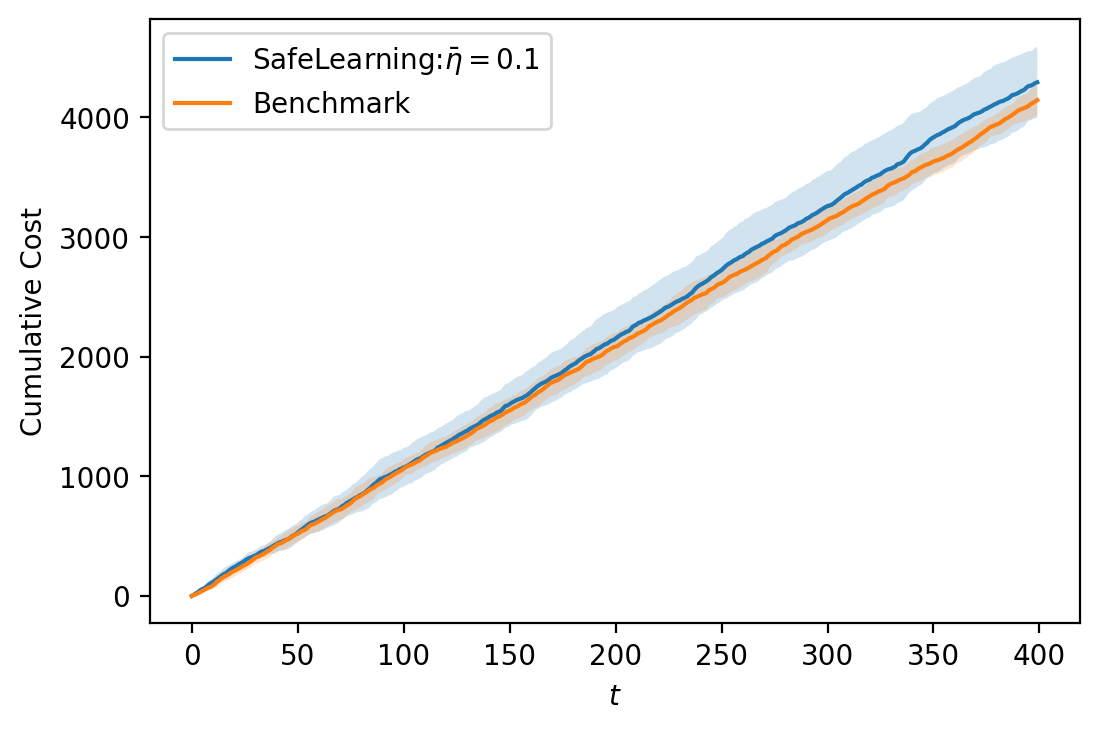

In [34]:
plt.figure(dpi=200)
ax = plt.gca()
for key,item in control_cost.items():
    if key == "SafeLearning":
        plot_with_errorband(ax,np.cumsum(item,axis=-1),label=r"{}:$\bar\eta={}$".format(key,0.1))
    else:
        plot_with_errorband(ax,np.cumsum(item,axis=-1),label=key)
ax.set_ylabel('Cumulative Cost')
ax.set_xlabel(r'$t$')
ax.legend()
plt.show()

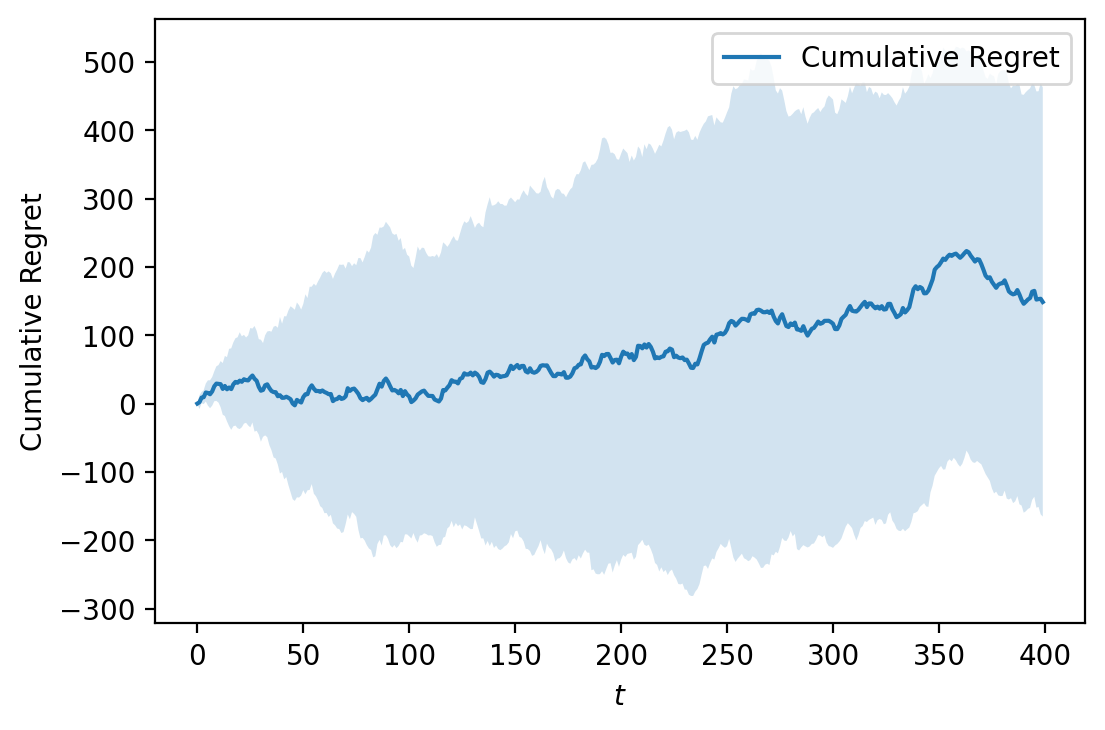

In [35]:
plt.figure(dpi=200)
ax = plt.gca()

plot_with_errorband(ax,np.cumsum(control_cost['SafeLearning']-control_cost['Benchmark'],axis=-1),label='Cumulative Regret')
ax.set_ylabel('Cumulative Regret')
ax.set_xlabel(r'$t$')
ax.legend()
plt.show()

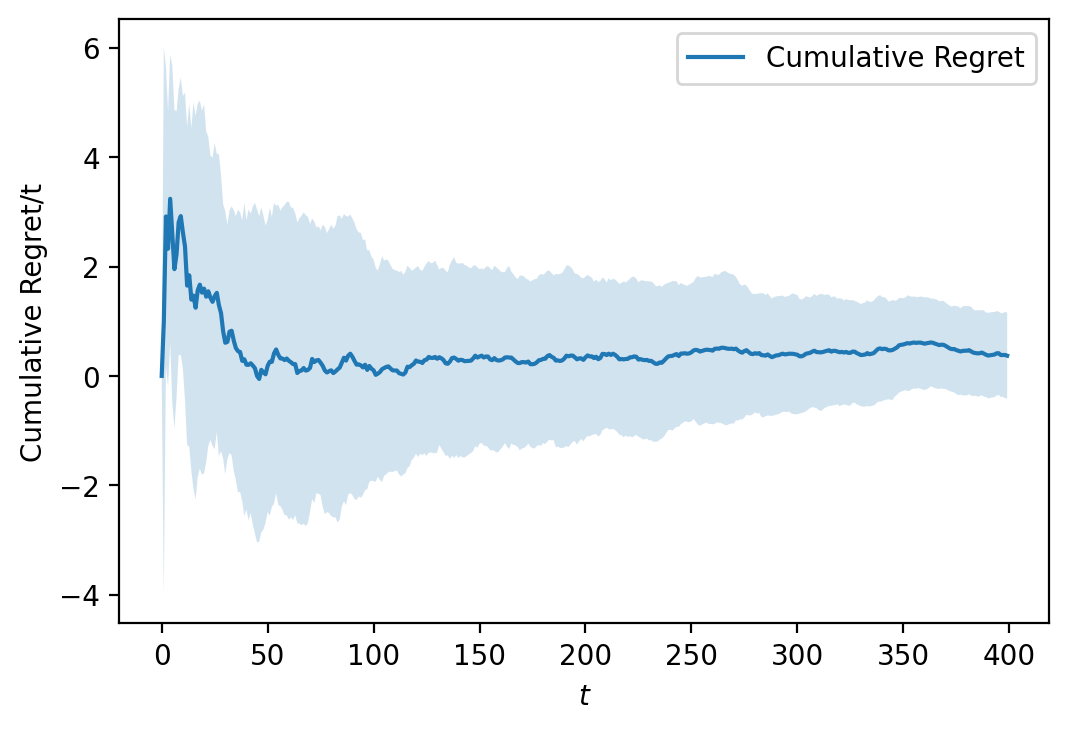

In [39]:
plt.figure(dpi=200)
ax = plt.gca()

times = np.arange(control_cost['SafeLearning'].shape[1])+1

plot_with_errorband(ax,np.cumsum(control_cost['SafeLearning']-control_cost['Benchmark'],axis=-1)/times,label='Cumulative Regret')
ax.set_ylabel('Cumulative Regret/t')
ax.set_xlabel(r'$t$')
ax.legend()
plt.show()

## Estimation error vs t.

In [16]:
thetas = [d['theta'] for d in data['SafeLearning']]
A = data['Parameters']['A']
B = data['Parameters']['B']

KeyError: 'SafeLearning'

In [ ]:
As = np.array([[t[0] for t in theta_hist] for theta_hist in thetas])
Bs = np.array([[t[1] for t in theta_hist] for theta_hist in thetas])

# As.shape = (# trials, # refits, x_dim, x_dim)
# Bs.shape = (# trials, # refits, x_dim, u_dim)

A_diff = np.linalg.norm(As-A,np.inf,axis=(-1,-2))
B_diff = np.linalg.norm(Bs-B,np.inf,axis=(-1,-2))